In [1]:
# !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
from utils.model import get_model
from utils.tools import AttrDict
import easydict
import torch
import yaml
import json

device = torch.device('cpu')

args = easydict.EasyDict()
args['restore_step'] = 300000
args['preprocess_config'] = './config/kss/preprocess.yaml'
args['model_config'] = './config/kss/model.yaml'
args['train_config'] = './config/kss/train.yaml'

preprocess_config = yaml.load(open(args.preprocess_config, "r"), Loader=yaml.FullLoader)
model_config = yaml.load(open(args.model_config, "r"), Loader=yaml.FullLoader)
train_config = yaml.load(open(args.train_config, "r"), Loader=yaml.FullLoader)

configs = (preprocess_config, model_config, train_config)

model = get_model(args, configs, device)

In [3]:
from utils.tools import to_device_inference, intersperse
from text import text_to_sequence
import json


def get_speaker_ids(path):
    with open(path, 'r', encoding='utf8') as j:
        speaker_ids = json.loads(j.read())
    return speaker_ids

def get_speaker_id(speaker, speaker_ids):
    return speaker_ids[speaker]

def get_text(sentence, preprocess_config):
    sequence = text_to_sequence(sentence)
    if preprocess_config["preprocessing"]["text"]["use_intersperse"]:
        sequence = intersperse(sequence, 0)
    return sequence

def get_pairs(speaker:str, sentence:str, speaker_ids:dict, preprocess_config:dict):
    speaker_id = torch.LongTensor([get_speaker_id('kss', speaker_ids, )]).long()
    sequence = torch.LongTensor(get_text(sentence, preprocess_config)).unsqueeze(0).long()
    src_lens = torch.LongTensor([sequence.size(0)]).long()
    max_src_len = src_lens.max().long()
    return (speaker_id, sequence, src_lens, max_src_len)

## Normal Synthesis

In [4]:
speaker_ids = get_speaker_ids('./preprocessed_data/kss/speakers.json')
speaker = 'kss'
sentence = '안녕하세요? 만나서 반갑습니다'

pairs = to_device_inference(
    get_pairs(speaker, sentence, speaker_ids, preprocess_config), 
    device
)

controls = {
    'p_control': 1.0, 
    'e_control': 1.0, 
    'd_control': 1.0, 
    'noise_scale': 0.666, 
}

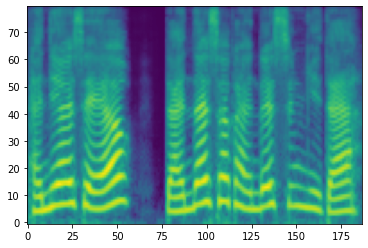

In [5]:
from data_utils import AudioTextProcessor
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline
processor = AudioTextProcessor(preprocess_config)
hop_size = processor.preprocess_config["preprocessing"]["stft"]["hop_length"]

output_gen = model(*(pairs), **(controls), gen=True)
wav_gen, wav_gen_len = output_gen[0], output_gen[9][0].item() * hop_size
wav_gen = wav_gen[0,0,:wav_gen_len]
mel_gen = processor.get_mel_energy(wav_gen.detach().cpu().numpy())[0]

plt.imshow(mel_gen, origin='lower', aspect='auto')
plt.show()

sr = preprocess_config['preprocessing']['audio']['sampling_rate']
display(ipd.Audio(wav_gen.detach().cpu().numpy(), rate=sr, normalize=False, autoplay=False))

## Voice Conversion

In [6]:
# voice conversion
speaker_ids = get_speaker_ids('./preprocessed_data/kss/speakers.json')
speaker = 'kss'
sentence = '안녕하세요? 만나서 반갑습니다'

pairs = to_device_inference(
    get_pairs(speaker, sentence, speaker_ids, preprocess_config), 
    device
)

speaker_id, sequence, src_lens, max_src_len = pairs
target_speaker_id = speaker_id # set another speaker id if you have multi-speaker model

Generated


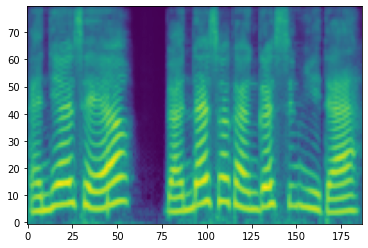

Converted


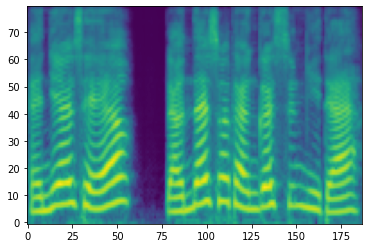

In [7]:
from data_utils import AudioTextProcessor
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline
processor = AudioTextProcessor(preprocess_config)
hop_size = processor.preprocess_config["preprocessing"]["stft"]["hop_length"]
sr = preprocess_config['preprocessing']['audio']['sampling_rate']

# normal synthesis
output_gen = model(*(pairs), **(controls), gen=True)
wav_gen, wav_gen_len = output_gen[0], output_gen[9][0].item() * hop_size
wav_gen = wav_gen[0,0,:wav_gen_len]
mel_gen = processor.get_mel_energy(wav_gen.detach().cpu().numpy())[0]

# voice conversion
input_mel = torch.from_numpy(mel_gen).unsqueeze(0)
input_mel_lengths = torch.LongTensor([input_mel.size(-1)])
input_mel_max_length = input_mel_lengths.max().item()
output_gen_vc = model.voice_conversion(
    mels=input_mel, 
    mel_lens=input_mel_lengths, 
    max_mel_len=input_mel_max_length, 
    sid_src=speaker_id, 
    sid_tgt=target_speaker_id)
wav_gen_vc = output_gen_vc[0][0,0,:None]
mel_gen_vc = processor.get_mel_energy(wav_gen_vc.detach().cpu().numpy())[0]

print("Generated")
plt.imshow(mel_gen, origin='lower', aspect='auto')
plt.show()
display(ipd.Audio(wav_gen.detach().cpu().numpy(), rate=sr, normalize=False, autoplay=False))

print("Converted")
plt.imshow(mel_gen_vc, origin='lower', aspect='auto')
plt.show()
display(ipd.Audio(wav_gen_vc.detach().cpu().numpy(), rate=sr, normalize=False, autoplay=False))